<a href="https://colab.research.google.com/github/AlexandreMinato/Investimentos_FII/blob/main/Analises_FII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# !pip install pandas numpy matplotlib lxml html5lib beautifulsoup4

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, datetime


# Capturando informacões
Capturando as informações do fundsexplorer para iniciar a analise. São 2 etapas:

1.   Informações gerais dos fundos imobiliarios
2.   Informações sobre pagamentos de variação de dividendos, oscilação, minimo, maximo e etc

O objetivo desta analise é encontrar fundos que pague dividendos sem muita oscilação, fundos com diversificação em seus ativos, que tenha liquidez e que tenha um valor justo (cota x valor patrimonial) adequado para compra

## 1) Informações gerais dos fundos imobiliarios - capturando informações

In [2]:
url = 'https://www.fundsexplorer.com.br/ranking'
dados = requests.get(url,  headers={'User-Agent': 'Mozilla/5.0'})
list_obj = pd.read_html(dados.text, attrs={'id': 'table-ranking'})
df = list_obj[0]

In [3]:
# redefinindo nome das colunas
df.columns = ['ativo',
              'setor',
              'preco',
              'liquidez_dia',
              'dividendo',
              'yield',
              'yield_3m_acululado',
              'yield_6m_acululado',
              'yield_12m_acululado',
              'yield_3m_media',
              'yield_6m_media',
              'yield_12m_media',
              'yield_ano',
              'variacao_preco',
              'rent_periodo',
              'rent_acumulada',
              'patrimonio_liq',
              'vpa',
              'p_vpa',
              'dy_patrimonial',
              'variacao_patrimonial',
              'rent_patr_periodo',
              'rent_acumulada_periodo',
              'vacancia_fisica',
              'vacancia_financeira',
              'quantidade_ativos']

In [4]:
df.head()

,ativo,setor,preco,liquidez_dia,dividendo,yield,yield_3m_acululado,yield_6m_acululado,yield_12m_acululado,yield_3m_media,...,patrimonio_liq,vpa,p_vpa,dy_patrimonial,variacao_patrimonial,rent_patr_periodo,rent_acumulada_periodo,vacancia_fisica,vacancia_financeira,quantidade_ativos
0,FIVN11,Shoppings,"R$ 2,97",26598.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%",...,"R$ 64.832.865,32","R$ 6,89",43.0,NaN,NaN,NaN,NaN,"56,00%",NaN,1
1,BZLI11,Títulos e Val. Mob.,"R$ 14,70",44041.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%",...,"R$ 439.665.897,40","R$ 11,45",128.0,NaN,NaN,NaN,NaN,NaN,NaN,0
2,XTED11,Lajes Corporativas,"R$ 7,13",6961.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%",...,"R$ 25.472.636,57","R$ 14,21",50.0,NaN,NaN,NaN,NaN,"0,00%","100,00%",1
3,ALMI11,Lajes Corporativas,"R$ 1.160,00",54.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%",...,"R$ 229.423.903,28","R$ 2.063,59",56.0,NaN,NaN,NaN,NaN,"68,15%",NaN,1
4,DOMC11,Lajes Corporativas,"R$ 439,00",42.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%",...,"R$ 264.351.778,61","R$ 108,17",406.0,NaN,NaN,NaN,NaN,"23,44%",NaN,1


### Normalizando as colunas

In [5]:
def identificar_conteudo_colunas(df, item):
    
    return [df[column].name for column in df if df[column].astype(str).str.contains(item).any()]

In [29]:
#Converter financeiro
coluna_monetario = identificar_conteudo_colunas(df, '\$')

for column_name in coluna_monetario:
    df[column_name] = df[column_name].str.replace('.', '', regex=False)
    df[column_name] = df[column_name].str.replace(',', '.', regex=False)
    df[column_name] = df[column_name].str.replace(r'[R\$ ,]', '', regex=True).astype(float)

In [7]:
# Converter as colunas de percentual em numericas
coluna_percentual = identificar_conteudo_colunas(df, '\%')
for column_name in coluna_percentual:
    df[column_name] = df[column_name].str.replace(',', '.')
    df[column_name] = df[column_name].str.replace(r'[%,]', '', regex=True).astype(float)
    df[column_name] = df[column_name]/100

In [8]:
# Normaliza o setor
df['setor'] = df['setor'].str.replace(r'\s+', '_', regex=True)
df['setor'] = df['setor'].str.replace(r'[^\w\s]+', '_', regex=True)
df['setor'] = df['setor'].str.lower()
df['setor'] = df['setor'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

## Iniciando as analises


In [9]:
df.setor.unique()

array(['shoppings', 'titulos_e_val__mob_', 'lajes_corporativas',
       'hibrido', 'outros', 'hotel', 'residencial', 'hospital',
       'logistica'], dtype=object)

In [10]:
df.ativo.nunique()

238

In [11]:
# Corrigindo o valor patrimonial por acao
df['p_vpa'] = df['p_vpa']/100

In [12]:
df.describe()

,preco,liquidez_dia,dividendo,yield,yield_3m_acululado,yield_6m_acululado,yield_12m_acululado,yield_3m_media,yield_6m_media,yield_12m_media,...,patrimonio_liq,vpa,p_vpa,dy_patrimonial,variacao_patrimonial,rent_patr_periodo,rent_acumulada_periodo,vacancia_fisica,vacancia_financeira,quantidade_ativos
count,228.000000,228.000000,238.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,...,2.380000e+02,238.000000,228.0000,32.000000,32.000000,32.000000,32.000000,116.000000,25.000000,238.000000
mean,519.537237,20790.521930,1.428655,0.009100,0.019889,0.033806,0.054202,0.006629,0.005633,0.004516,...,5.148981e+08,662.393866,inf,0.006094,0.001256,0.007344,0.017137,0.155611,0.126088,3.361345
std,5642.093586,72286.168052,4.710741,0.030498,0.032587,0.038822,0.055598,0.010861,0.006472,0.004633,...,7.104481e+08,6211.667603,NaN,0.002374,0.003671,0.003858,0.013089,0.228239,0.232145,7.999716
min,0.750000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-5.941591e+06,-7.830000,-1.6000,0.001000,-0.003700,0.000900,-0.014600,0.000000,0.000000,0.000000
25%,82.412500,264.500000,0.392500,0.004200,0.010450,0.015575,0.000000,0.003475,0.002600,0.000000,...,1.030673e+08,93.750000,0.8475,0.005325,-0.000325,0.005375,0.012400,0.000000,0.000000,0.000000
50%,98.390000,2308.000000,0.625000,0.006100,0.017500,0.032850,0.058350,0.005800,0.005450,0.004900,...,2.621177e+08,99.915000,0.9700,0.005900,0.000450,0.006550,0.017550,0.054950,0.036000,1.000000
75%,111.130000,17359.500000,0.930000,0.007700,0.022175,0.044050,0.079425,0.007425,0.007325,0.006600,...,5.922617e+08,109.795000,1.0300,0.007050,0.002150,0.009400,0.024550,0.213250,0.123000,3.000000
max,85227.760000,890062.000000,52.680000,0.363200,0.379900,0.409600,0.452200,0.126600,0.068300,0.037700,...,4.852707e+09,93717.970000,inf,0.011900,0.015300,0.021300,0.045000,1.000000,1.000000,72.000000


In [13]:
df.setor.unique()

array(['shoppings', 'titulos_e_val__mob_', 'lajes_corporativas',
       'hibrido', 'outros', 'hotel', 'residencial', 'hospital',
       'logistica'], dtype=object)

In [14]:
# filtrando setores que eu gosto
df = df[df['setor'] \
        .isin(['shoppings', 'titulos_e_val__mob_', 'lajes_corporativas', 'hibrido', 'logistica'])].copy()

In [15]:
df.setor.unique()

array(['shoppings', 'titulos_e_val__mob_', 'lajes_corporativas',
       'hibrido', 'logistica'], dtype=object)

### Condicoes para filtrar os FIIs

In [16]:
#Preco aceitavel para pagamento, considerando cota e valor patrimonial
df['preco_justo'] = np.where((df['p_vpa'] > 0.9) & (df['p_vpa'] < 1.1) , True, False)

setores_considerar = ['shoppings', 'lajes_corporativas', 'logistica']

# Criando filtros
diversificacoes_ativos = [
    # Condicoes de setores que gosto com mais de 5 ativos
    (df['setor'].isin(setores_considerar)) & 
    (df['quantidade_ativos'] > 5),
    # Condicoes de setores que gosto com menos de 5 ativos 
    # (inativo na hora de aplicar o filtro, deixei aqui, 
    # caso queira olhar para fundos com pouca diversificação,
    # bastante alterar a variavel diversificacoes_aceitaveis para True, True, True)
    (df['setor'].isin(setores_considerar)) &
    (df['quantidade_ativos'] < 5),
    # setores
    (~df['setor'].isin(setores_considerar))
]
#Aplicacao dos filtros
diversificacoes_aceitaveis = [True, False, True]
df['ativos_diversificados'] = np.select(diversificacoes_ativos, diversificacoes_aceitaveis, default=None)

# imovel com vacancia aceitavel
df['vacancia_aceitavel'] = np.where((df['vacancia_fisica'] < 0.1) | \
                                    (df['vacancia_fisica'].isnull()) | \
                                    (df['vacancia_fisica'].isnull()) , True, False)

# Fundo que tenham liquidez
df['liquidez'] = np.where(df['liquidez_dia'] > 20000, True, False)

# Fundos que pagam dividendos acima de 0,5%, considerando o acumulado de 12 meses
df['dividendos_minimos'] = np.where(df['yield_12m_acululado'] > 0.05, True, False)

### Criando as condições dos filtros

In [17]:
condicoes_ativos = (
    df.preco_justo &
    df.ativos_diversificados &
    df.vacancia_aceitavel &
    df.liquidez &
    df.dividendos_minimos
)
df_results = df.loc[condicoes_ativos].sort_values(by=['yield_12m_acululado', 'liquidez_dia'], ascending=False)
df_results = df_results.set_index('ativo')

# Analisando os resultados
*Os papéis abaixo atendem aos filtros de diversificação e preço justo.

In [18]:
df_results

,setor,preco,liquidez_dia,dividendo,yield,yield_3m_acululado,yield_6m_acululado,yield_12m_acululado,yield_3m_media,yield_6m_media,...,rent_patr_periodo,rent_acumulada_periodo,vacancia_fisica,vacancia_financeira,quantidade_ativos,preco_justo,ativos_diversificados,vacancia_aceitavel,liquidez,dividendos_minimos
ativo,,,,,,,,,,,,,,,,,,,,,
RECR11,titulos_e_val__mob_,101.55,96545.0,1.10,0.0100,0.0280,0.0673,0.1232,0.0093,0.0112,...,NaN,NaN,NaN,NaN,0,True,True,True,True,True
CVBI11,titulos_e_val__mob_,104.81,22751.0,1.00,0.0094,0.0287,0.0732,0.1171,0.0096,0.0122,...,NaN,NaN,NaN,NaN,0,True,True,True,True,True
BCRI11,titulos_e_val__mob_,112.25,23172.0,1.59,0.0138,0.0365,0.0627,0.1116,0.0122,0.0105,...,NaN,NaN,NaN,NaN,0,True,True,True,True,True
CPTS11,titulos_e_val__mob_,99.60,114068.0,1.05,0.0104,0.0307,0.0615,0.1064,0.0102,0.0102,...,NaN,NaN,NaN,NaN,0,True,True,True,True,True
KNIP11,titulos_e_val__mob_,107.50,100789.0,1.13,0.0103,0.0280,0.0611,0.1012,0.0093,0.0102,...,NaN,NaN,NaN,NaN,0,True,True,True,True,True
CPFF11,hibrido,83.03,26986.0,0.82,0.0099,0.0286,0.0578,0.0814,0.0095,0.0096,...,NaN,NaN,NaN,NaN,0,True,True,True,True,True
MXRF11,hibrido,10.43,890062.0,0.07,0.0066,0.0218,0.0434,0.0806,0.0073,0.0072,...,NaN,NaN,NaN,NaN,0,True,True,True,True,True
VINO11,lajes_corporativas,60.30,27658.0,0.45,0.0075,0.0221,0.0431,0.0799,0.0074,0.0072,...,NaN,NaN,0.0370,NaN,9,True,True,True,True,True
RBRF11,titulos_e_val__mob_,89.16,46850.0,0.60,0.0065,0.0194,0.0423,0.0798,0.0065,0.0070,...,0.0100,0.0100,NaN,NaN,0,True,True,True,True,True


## Simulando valor de investimento para calcular o retorno (forecast)

In [30]:

valor_investir = 20000
df_results['valor_investir'] = (valor_investir / df_results.preco)
df_results['valor_investir'] = df_results['valor_investir'].astype(int)
df_results['resultado_previsto'] = df_results['valor_investir'] \
                                        .astype(int) * df_results['dividendo'].astype(float)
df_results[['preco', 'dividendo', 'yield', 'valor_investir', 'resultado_previsto']]

,preco,dividendo,yield,valor_investir,resultado_previsto
ativo,,,,,
RECR11,101.55,1.10,0.0100,196,215.60
CVBI11,104.81,1.00,0.0094,190,190.00
BCRI11,112.25,1.59,0.0138,178,283.02
CPTS11,99.60,1.05,0.0104,200,210.00
KNIP11,107.50,1.13,0.0103,186,210.18
CPFF11,83.03,0.82,0.0099,240,196.80
MXRF11,10.43,0.07,0.0066,1917,134.19
VINO11,60.30,0.45,0.0075,331,148.95
RBRF11,89.16,0.60,0.0065,224,134.40


<BarContainer object of 21 artists>

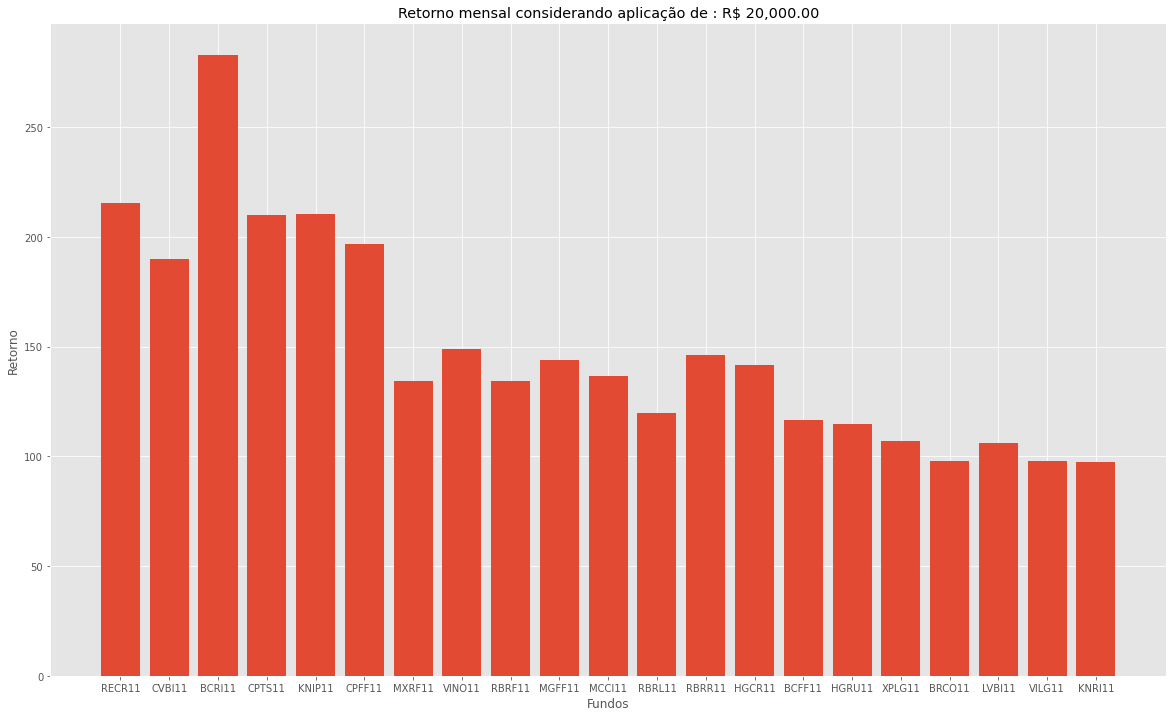

In [31]:
titulo = 'Retorno mensal considerando aplicação de : ' + "R$ {:,.2f}". format(valor_investir)
plt.style.use("ggplot")
plt.figure(figsize = (20, 12))
plt.title(titulo)
plt.xlabel("Fundos")
plt.ylabel("Retorno")
plt.bar(df_results.index, df_results.resultado_previsto)

# Etapa 2: consulta de pagamento dos dividendos mensais de cada fundo

In [32]:
def capturar_valor_rendimentos(codFII):
    url_rend = 'https://fiis.com.br/' + codFII
    dados_rend = requests.get(url_rend,  headers={'User-Agent': 'Mozilla/5.0'})
    tb_rend = pd.read_html(dados_rend.text, attrs={'id': 'last-revenues--table'})
    df_rend = tb_rend[0]  
    df_rend.columns = ['data_base', 'data_pagamento', 'cotacao_base', 'div_yield', 'rendimento']
    df_rend.insert(0,'ativo', codFII)
    df_rend.set_index('ativo')

    coluna_monetario = identificar_conteudo_colunas(df_rend, '\$')
    for column_name in coluna_monetario:
        df_rend[column_name] = df_rend[column_name].str.replace('.', '', regex=False)
        df_rend[column_name] = df_rend[column_name].str.replace(',', '.', regex=False)
        df_rend[column_name] = df_rend[column_name].str.replace(r'[R\$ ,]', '', regex=True).astype(float)

    coluna_percentual = identificar_conteudo_colunas(df_rend, '\%')
    for column_name in coluna_percentual:
        df_rend[column_name] = df_rend[column_name].str.replace(',', '.', regex=False)
        df_rend[column_name] = df_rend[column_name].str.replace(r'[%,]', '', regex=True).astype(float)
        df_rend[column_name] = df_rend[column_name]/100

    #Converter colunas de datas
    coluna_data = identificar_conteudo_colunas(df_rend, '\/')
    for column_name in coluna_data:
        df_rend[column_name] = df_rend[column_name].apply(lambda x: datetime.strptime(x, '%d/%m/%y'))
      
    df_result = df_rend.groupby('ativo').agg({'rendimento': ['min','max', 'median', 'var', 'mean', 'quantile']})
    df_result.columns = ['minimo','maximo', 'mediana', 'variacao', 'media', 'quartil']
    return df_result

In [33]:
df_union = pd.DataFrame(columns=['minimo','maximo', 'mediana', 'variacao', 'media', 'quartil']) 

for ind in df_results.index:
    df_union = df_union.append([capturar_valor_rendimentos(ind)])

In [34]:
df_union_data = pd.concat([df_union, df_results], axis=1)

# Cruzando informacoes gerais do fundo (vacancia, liquidez e etc) com rendimentos pagos (minimo, maximo, desvio padrao e etc)

<AxesSubplot:>

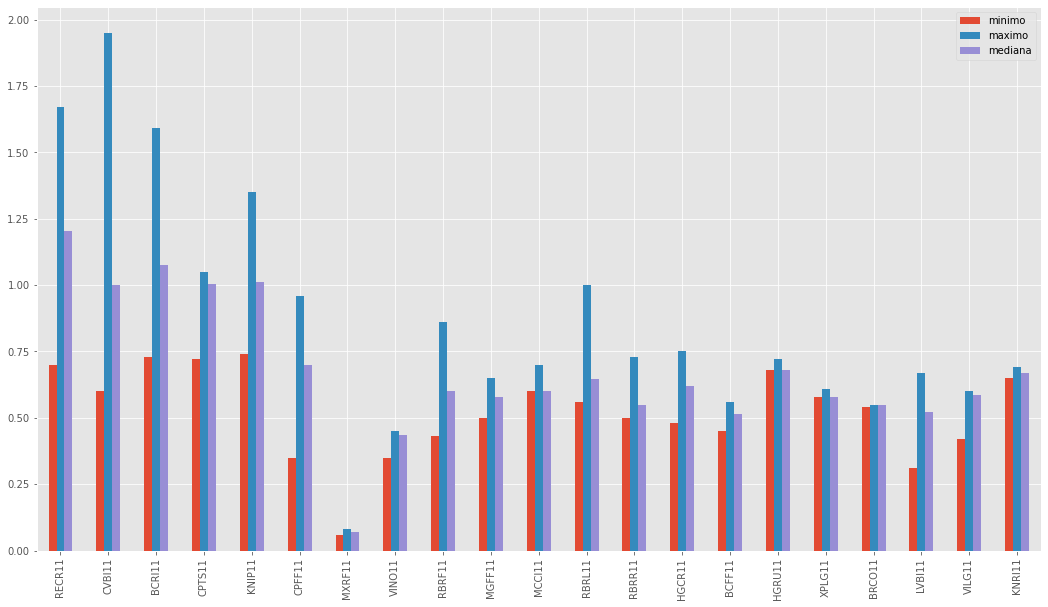

In [35]:
plt.style.use('ggplot')
df_union_data[['minimo', 'maximo', 'mediana']].plot(figsize = (18, 10), grid=True, kind='bar')

<AxesSubplot:>

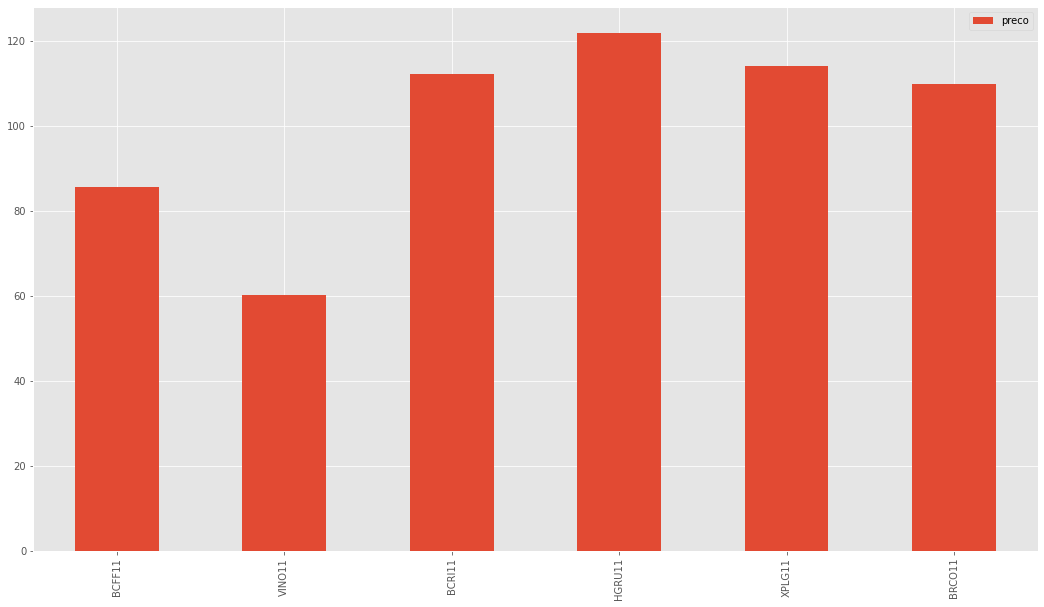

In [36]:
df_union_data[['preco']] \
    .loc[['BCFF11', 'VINO11', 'BCRI11', 'HGRU11', 'XPLG11', 'BRCO11']] \
    .plot(figsize = (18, 10), grid=True, kind='bar')

In [37]:
df_results[['preco', 'dividendo', 'yield', 'resultado_previsto']] \
    .loc[['BCFF11', 'VINO11', 'BCRI11', 'HGRU11', 'XPLG11', 'BRCO11']] \
    .sort_values(by=['yield'], ascending=False)

,preco,dividendo,yield,resultado_previsto
ativo,,,,
BCRI11,112.25,1.59,0.0138,283.02
VINO11,60.30,0.45,0.0075,148.95
HGRU11,121.94,0.70,0.0058,114.80
BCFF11,85.71,0.50,0.0057,116.50
XPLG11,114.10,0.61,0.0054,106.75
BRCO11,110.00,0.54,0.0049,97.74
